In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [2]:
utterance = '''Marco: From My Sight,  I think Flavia's  totally underrating yesterdays day  right?  It was absolutely astonishing how scribble  was  like, excited  about what we showed them  crazy gave you showed  their problem, is they lost  conversions. in t last three weeks.  They didn't know why they assumed its Nexoya maybe even,  they lost like, 21% of conversions,  like, literally bottom line conversions big problem for them.  
Big risk  and we made an analysis over all our clients and show that the average client is loosing 41 percent in the last  25 days  because of the  crockpot potentially because of the war situation, and  they are actually oa good track,  his quote was, I can now sleep again nicely  because I couldn't sleep last three weeks because this problem, I didn't know what's the problem. 
And I thought, maybe it's even Nexoya.  So the marketing intelligence, which we showed him  was priceless for him.  Like it felt like  he didn't really want to look at the optimization. He was like, yeah. All fine.  We'll just apply it.  Right,  so he was super, super happy. And  we also showed in the morning Assura, where the director client director, even wrote me on chat afterwards. Hey amazing, insights thanks a lo. We will  look at other clients and  same. I think also on Iway. He loved the dashboard. I don't know if he loved the Market insights but he loved the dashboards,  and we now look forward in ZKB, Clara. We  look at every customer,  Klara has it  ZKB has it  same pattern, same problem.  If you wlook at it. Look at the 
dashboard  scroll at the bottom you see in marketing intelligence  field.'''
summary = '''Marco was at a meeting yesterday. The client was excited about the insights they showed him. They lost 21% of conversions in 3 weeks. The average client is losing 41% in the last 25 days. Klara and ZKB have the same problem. '''

In [3]:
import nltk
import numpy as np

# input_tokens = list(tokenizer.convert_ids_to_tokens(tokenizer.encode(utterance)))
# output_tokens = list(tokenizer.convert_ids_to_tokens(tokenizer.encode(summary)))

stop_words = set(nltk.corpus.stopwords.words('english'))
nltk_tokenizer = nltk.RegexpTokenizer(r"\w+")
input_tokens = nltk_tokenizer.tokenize(utterance)
input_tokens = [w for w in input_tokens if not w.lower() in stop_words]
output_tokens = nltk_tokenizer.tokenize(summary)
output_tokens = [w for w in output_tokens if not w.lower() in stop_words]



In [4]:
from collections import OrderedDict

def compute_matches(input_tokens, output_tokens):
    matches = OrderedDict()
    for in_index in range(len(input_tokens)):
        i,o, = in_index, 0
        cur_index_range = []
        curr_str = []

        while i < len(input_tokens) and o < len(output_tokens):
            if input_tokens[i].lower() == output_tokens[o].lower():
                '''
                    Append token if it appears at the same spot in both input and output
                    input_tokens=     ['this', 'is', 'the', 'input']
                                                    i
                    output_tokens=    ['the', 'input']
                                        o
                    curr_str=['the']
                    curr_index_range=[2] 
                '''
                cur_index_range.append(i)
                curr_str.append(input_tokens[i])
                i, o = i+1, o+1
            else:
                if i-1 in cur_index_range:
                    '''
                        Check if last token was added in the index range - used for softening the constraint 
                        so one token can be skipped and still account for the n-gram succession
                        input_tokens=     ['this', 'is', 'the', 'someword' 'input']
                                                                    i
                        output_tokens=    ['the', 'input']
                                                    o
                        curr_str=['the']
                        curr_index_range=[2]
                        i += 1 
                    '''
                    i += 1
                elif len(curr_str) > 0:
                    matches['_'.join([str(i) for i in cur_index_range])] = curr_str
                    cur_index_range = []
                    curr_str = []
                    o += 1
                else:
                    o += 1
    return matches


def compute_max_n_gram(matches_dict):
    indexes_with_length = OrderedDict()

    for index_group in matches_dict.keys():
        indexes = index_group.split('_')
        for idx in indexes:
            if idx in indexes_with_length:
                if indexes_with_length[idx] < len(indexes):
                    indexes_with_length[idx] = len(indexes)
            else:
                indexes_with_length[idx] = len(indexes)

    return indexes_with_length

def deduplicate_matches(matches_dict, max_n_grams_per_idx):
    # Deduplicate based on index
    deduplicated_matches = []
    for key in matches_dict.keys():
        indexes = key.split('_')
        is_longest = True
        for idx in indexes:
            if max_n_grams_per_idx[idx] > len(indexes):
                is_longest = False

        if is_longest:
            deduplicated_matches.append(matches_dict[key])
    
    # Deduplicate 1-grams based on word occurence
    seen = set()
    deduplicated_words = []
    for n_gram in deduplicated_matches:
        if len(n_gram) == 1:
            if n_gram[0] in seen:
                continue
            else:
                seen.add(n_gram[0])
                deduplicated_words.append(n_gram)
        else:
            for word in n_gram:
                if word not in seen:
                    seen.add(word)
            deduplicated_words.append(n_gram)

    return [' '.join(i) for i in deduplicated_words]


In [5]:
matches_dict = compute_matches(input_tokens, output_tokens)
max_n_grams_per_idx = compute_max_n_gram(matches_dict)
deduplicate_matches(matches_dict, max_n_grams_per_idx)


['Marco',
 'excited',
 'showed',
 'showed lost',
 'last',
 'conversions',
 'weeks',
 'lost 21 conversions',
 'average client',
 '41 last 25 days',
 'insights',
 'ZKB']

<AxesSubplot:>

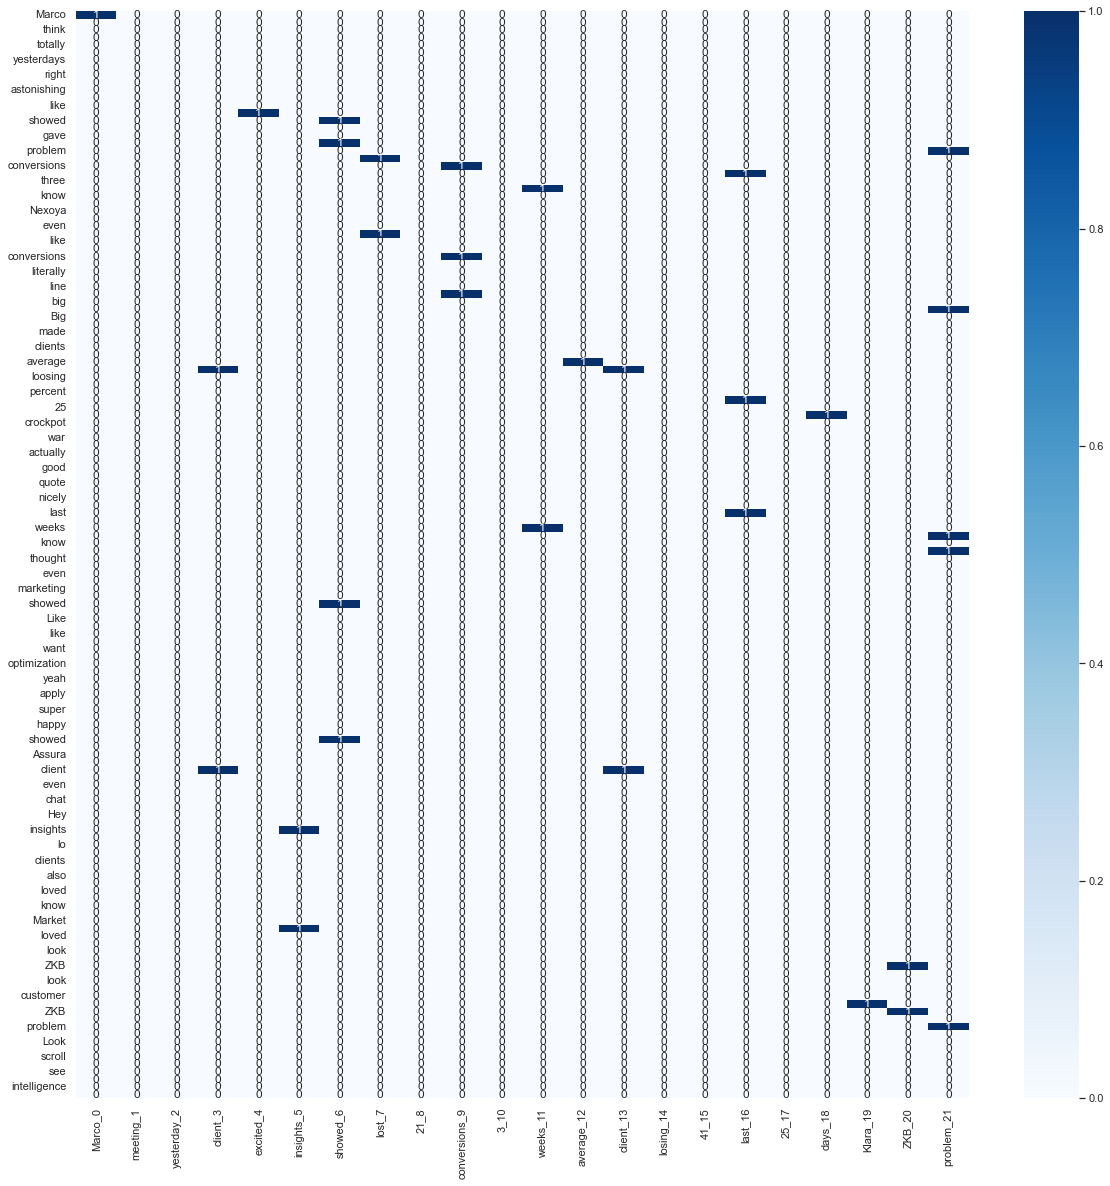

In [7]:
import pandas as pd
import seaborn as sns 
output_dict = {f'{token}_{i}': np.zeros(len(input_tokens)) for i,token in enumerate(output_tokens)}
for i, i_token in enumerate(input_tokens):
    if len(i_token) < 3 : 
        continue
    output_keys = [i for i in list(output_dict.keys()) if i.split('_')[0] == i_token]
    if len(output_keys) > 0:
        for key in output_keys:
            output_dict[key][i] = 1

df = pd.DataFrame(output_dict) 
df.index = input_tokens
sns.set(rc={"figure.figsize":(20, 20)})
sns.heatmap(df, cmap = 'Blues', annot = True)